<a href="https://colab.research.google.com/github/krishnarevi/TSAI_END2.0_Session7/blob/main/Quora_Dataset_Seq2seq_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation with Quora Question Pairs Dataset 
Here we will be building a sequence to sequence deep learning model using PyTorch and TorchText for prediction of duplicate questions .Sequence to Sequence (seq2seq) model here uses an encoder-decoder architecture. Encoder neural network encodes the input sequence(question1) into a single vector, also called as a Context Vector,which is an abstract representation of the input sequence.This vector is then passed into the decoder neural network, which is used to output the corresponding output sequence (duplicate), one word at a time

##  Preparing Data
Import all the required modules and  set the random seeds for deterministic results.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim


from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time
import torch, torchtext
from torchtext import legacy
from torchtext.legacy import data


Mount drive to access dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
path='/content/drive/MyDrive/TSAI_data/'

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
# !pip install spacy --upgrade
# import dependencies
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

## Dataset
We will be using first public dataset of Quora released in january 2017 .The Quora dataset consists of a large number of question pairs and a label which mentions whether the question pair is logically duplicate or not. For example, two questions below carry the same intent.

*“What is the most populous state in the USA?”*

*“Which state in the United States has the most people?”* 

Ideally, only one of the two should be present on Quora.

The data set consisted of around 400,000 pairs of questions organized in the form of 6 columns as explained -


*   id: Row ID
*   qid 1, qid 2: The unique ID of each question in the pair
*  question 1, question 2: The actual textual contents of the questions.
*  is_duplicate: Label is 0 for questions which are semantically different and 1 for questions which essentially would have only one answer (duplicate questions)

63% of the questions pairs are semantically non-similar and 37% are duplicate questions pairs.We will consider only questions with duplicates for our modeling

Let's view first few lines of dataset

In [5]:
df=pd.read_csv(path+"quora_duplicate_questions.tsv",sep='\t')
df= df.iloc[:,3:]
df.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
print(f'Length of dataset \n{len(df)}')

Length of dataset 
404290


Let's view label distribution

In [7]:
print(f"Number of duplicate questions: {df['is_duplicate'].value_counts()[0]}")
print(f"Number of non-duplicate questions: {df['is_duplicate'].value_counts()[1]}")

Number of duplicate questions: 255027
Number of non-duplicate questions: 149263


In [8]:
print(f'The duplicate questions are {df.is_duplicate.value_counts()[0]/len(df)*100}% of the entire dataset')
print(f'The non-duplicate questions are {df.is_duplicate.value_counts()[1]/len(df)*100}% of the entire dataset')

The duplicate questions are 63.08021469737069% of the entire dataset
The non-duplicate questions are 36.9197853026293% of the entire dataset


Next we will do some preprocessing ,we will remove all non duplicate entries and unwanted columns from our dataset

In [9]:

final_df=df.loc[df['is_duplicate']==1].reset_index(drop=True)
final_df=final_df.iloc[:,:2]
final_df

,question1,question2
0,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan..."
1,How can I be a good geologist?,What should I do to be a great geologist?
2,How do I read and find my YouTube comments?,How can I see all my Youtube comments?
3,What can make Physics easy to learn?,How can you make physics easy to learn?
4,What was your first sexual experience like?,What was your first sexual experience?
...,...,...
149258,What are some outfit ideas to wear to a frat p...,What are some outfit ideas wear to a frat them...
149259,Why is Manaphy childish in Pokémon Ranger and ...,Why is Manaphy annoying in Pokemon ranger and ...
149260,How does a long distance relationship work?,How are long distance relationships maintained?
149261,What does Jainism say about homosexuality?,What does Jainism say about Gays and Homosexua...


Now split dataset into train and test for modeling

In [10]:

(df_train, df_test) = train_test_split(final_df, test_size=0.3, random_state=random.seed(SEED))

assert len(df_train) + len(df_test) == len(final_df)
df_train=df_train.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)

Let's view length of train and test dataframes

In [11]:
len(df_train),len(df_test)

(104484, 44779)

Load spacy model for tokenizing

In [12]:
!pip install spacy --upgrade --quite


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --quite


In [13]:
%%bash

python -m spacy download en --quite
# python -m spacy download de


Usage:   
  /usr/bin/python3 -m pip install [options] <requirement specifier> [package-index-options] ...
  /usr/bin/python3 -m pip install [options] -r <requirements file> [package-index-options] ...
  /usr/bin/python3 -m pip install [options] [-e] <vcs project url> ...
  /usr/bin/python3 -m pip install [options] [-e] <local project path> ...
  /usr/bin/python3 -m pip install [options] <archive url/path> ...

no such option: --quite


In [14]:
# spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

We create the tokenizer.

In [15]:
# def tokenize_de(text):
#     """
#     Tokenizes German text from a string into a list of strings (tokens) and reverses it
#     """
#     return [tok.text for tok in spacy_en.tokenizer(text)][::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

Here our source (SRC - Input) is question 1 and target (TRG - Output) is question 2. We also add 2 extra tokens "start of sequence" and "end of sequence" for effective model training.

In [16]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

Define fields to decide how we process data

In [17]:
fields=[('question1',SRC),('question2',TRG)]

In [18]:
df_train

,question1,question2
0,What is scope for international students who w...,What is the scope for mechanical engineers for...
1,What is shadow banking? Can you explain it in ...,What is shadow banking? Can anyone explain it ...
2,What is the difference between Jainism and Bud...,What are the differences between Jainism and B...
3,What is the best programming blog?,What is the best programming blogs?
4,What are some mind blowing Magic science trick...,What are some mind-blowing science magic trick...
...,...,...
104479,What is the meaning of Sandeep?,What is the meaning of the name Sandeep?
104480,How do you delete pictures on Instagram at once?,How do you delete all of your Instagram photos...
104481,What is A brand strategist?,What does a brand strategist do?
104482,How should I start to learn c language?,How can I study c language?


Now we create train and test dataset from list of rows

In [19]:
example_train=[data.Example.fromlist([df_train.question1[i],df_train.question2[i]],fields) for i in range (df_train.shape[0])]
example_test=[data.Example.fromlist([df_test.question1[i],df_test.question2[i]],fields) for i in range (df_test.shape[0])]

In [20]:
train_data = torchtext.legacy.data.Dataset(example_train, fields)
test_data= torchtext.legacy.data.Dataset(example_test,fields)

In [21]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 104484
Number of testing examples: 44779



Let's look at one of the examples in the training set

In [22]:
print(vars(train_data.examples[0]))

{'question1': ['what', 'is', 'scope', 'for', 'international', 'students', 'who', 'will', 'study', 'ms', 'in', 'usa', 'in', 'mechanical', 'streams', '?'], 'question2': ['what', 'is', 'the', 'scope', 'for', 'mechanical', 'engineers', 'for', 'a', 'master', "'s", 'in', 'the', 'usa', 'with', 'good', 'pay', 'after', 'an', 'ms', '?']}


Build vocabulary

In [23]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [24]:
print(f"Unique tokens in source (en) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (en) vocabulary: 14519
Unique tokens in target (en) vocabulary: 14505


Define device

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Create iterators

In [26]:
BATCH_SIZE = 128

train_iterator, test_iterator = BucketIterator.splits(
    (train_data,  test_data), 
    batch_size = BATCH_SIZE,sort_within_batch = True,
    sort_key = lambda x: len(x.question1),
    device = device)

#  **Build Model**

 ## Encoder
 First, the encoder, a 2 layer `LSTM`.

For a multi-layer LSTM, the input sentence, $X$, after being embedded goes into the first (bottom) layer of the LSTM.Along with input sequence , LSTM take in hidden state and cell state from previous time step and return new hidden state and cell state at each time step.Initial hidden state and cell state will be initialized to tensor of all zeros.Only hidden state from the first layer is passed as input to the second layer, and not the cell state.We will also output a context vector per layer, $z^l$.Our context vector will be both the final hidden state and the final cell state, i.e. $z^l = (h_T^l, c_T^l)$.

Thus, representing each layer with a superscript, the hidden states in each layer are given by:

$$\begin{align*}
(h_t^1, c_t^1) = \text{EncoderLSTM}^1(e(x_t), (h_{t-1}^1, c_{t-1}^1))\\
(h_t^2, c_t^2) = \text{EncoderLSTM}^2(h_t^1, (h_{t-1}^2, c_{t-1}^2))
\end{align*}$$
We create this in code by making an `Encoder` module, which inherit from `torch.nn.Module` and use the `super().__init__()` as some boilerplate code. The encoder takes the following arguments:

*  `input_dim` is the size/dimensionality of the one-hot vectors that will be input to the encoder. This is equal to the input (source) vocabulary size.

*  `emb_dim` is the dimensionality of the embedding layer. This layer converts the one-hot vectors into dense vectors with emb_dim dimensions.
*   `hid_dim` is the dimensionality of the hidden and cell states.
*   `n_layers` is the number of layers in the LSTM.
* `dropout` is the amount of dropout to use. This is a regularization parameter to prevent overfitting.


In the `forward` method, we pass in the source sentence, $X$, which is converted into dense vectors using the embedding layer, and then dropout is applied. These embeddings are then passed into the LSTM. As we pass a whole sequence to the LSTM, it will automatically do the recurrent calculation of the hidden states over the whole sequence.We do not pass an initial hidden or cell state to the LSTM. This is because, if no hidden/cell state is passed to the LSTM, it will automatically create an initial hidden/cell state as a tensor of all zeros.

The `LSTM` returns: `outputs` (the top-layer hidden state for each time-step), hidden (the final hidden state for each layer, $h_T$, stacked on top of each other) and `cell` (the final cell state for each layer, $c_T$, stacked on top of each other).

As we only need the final hidden and cell states (to make our context vector), `forward` only returns hidden and cell.

In [27]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        

        self.hid_dim = hid_dim
        
        # Number of layers in the lstm
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_dim, emb_dim)

        

        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)

        # Regularization parameter
        self.dropout = nn.Dropout(dropout)
  
    def forward(self, src):
        # print(f'En-shape of src{src.shape}')#[8, 128]
 
        embedded = self.dropout(self.embedding(src))
        # print(f'En-shape of embedded{embedded.shape}')#[8, 128, 256]

        outputs, (hidden, cell) = self.rnn(embedded)
        # print(f'En-shape of outputs{outputs.shape}')#[8, 128, 512]
        # print(f'En-shape of hidden{hidden.shape}')#[2, 128, 512]

        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

### Decoder 
Next, we'll build our `decoder`, which will also be a 2-layer `LSTM`.

The Decoder class does a single step of decoding, i.e. it ouputs single token per time-step. The first layer will receive a hidden and cell state from the previous time-step, $(s_{t-1}^1, c_{t-1}^1)$, and feeds it through the `LSTM` with the current embedded token, $y_t$, to produce a new hidden and cell state, $(s_t^1, c_t^1)$. The subsequent layers will use the hidden state from the layer below, $s_t^{l-1}$, and the previous hidden and cell states from their layer, $(s_{t-1}^l, c_{t-1}^l)$. This provides equations very similar to those in the encoder.

$$\begin{align*}
(s_t^1, c_t^1) = \text{DecoderLSTM}^1(d(y_t), (s_{t-1}^1, c_{t-1}^1))\\
(s_t^2, c_t^2) = \text{DecoderLSTM}^2(s_t^1, (s_{t-1}^2, c_{t-1}^2))
\end{align*}$$
Remember that the initial hidden and cell states to our decoder are our context vectors, which are the final hidden and cell states of our encoder from the same layer, i.e. $(s_0^l,c_0^l)=z^l=(h_T^l,c_T^l)$.

We then pass the hidden state from the top layer of the RNN, $s_t^L$, through a linear layer, $f$, to make a prediction of what the next token in the target (output) sequence should be, $\hat{y}_{t+1}$.

$$\hat{y}_{t+1} = f(s_t^L)$$
The arguments and initialization are similar to the Encoder class, except we now have an output_dim which is the size of the vocabulary for the output/target. There is also the addition of the Linear layer, used to make the predictions from the top layer hidden state.

Within the forward method, we accept a batch of input tokens, previous hidden states and previous cell states. As we are only decoding one token at a time, the input tokens will always have a sequence length of 1. We unsqueeze the input tokens to add a sentence length dimension of 1. Then, similar to the encoder, we pass through an embedding layer and apply dropout. This batch of embedded tokens is then passed into the RNN with the previous hidden and cell states. This produces an output (hidden state from the top layer of the RNN), a new hidden state (one for each layer, stacked on top of each other) and a new cell state (also one per layer, stacked on top of each other). We then pass the output (after getting rid of the sentence length dimension) through the linear layer to receive our prediction. We then return the prediction, the new hidden state and the new cell state.

In [28]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        

        self.output_dim = output_dim

        self.hid_dim = hid_dim
        
        # Number of layers in the lstm
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)

        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        # Regularization parameter
        self.dropout = nn.Dropout(dropout)
    
    # Shape of input [batch_size]  
    def forward(self, input, hidden, cell):
        # print(f'De-shape of input{input.shape}')#[128]

        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        # print(f'De-shape of input{input.shape}')#[1, 128]
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        # print(f'De-shape of embedded{embedded.shape}') #[1,128,256]   
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # print(f'De-shape of output{output.shape}')#[1,128,512]
        # print(f'De-shape of hidden{hidden.shape}')#[2,128,512]
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
  
        prediction = self.fc_out(output.squeeze(0))# [128, 1271]
        # print(f'De-shape of prediction{prediction.shape}')
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

## Seq2Seq (Encoder + Decoder) 
For the final part of the implemenetation, we'll implement the `seq2seq` model. This will handle:





*   receiving the input/source sentence
*   using the encoder to produce the context vectors
*   using the decoder to produce the predicted output/target sentence



The `Seq2Seq` model takes in an Encoder, Decoder, and a device (used to place tensors on the GPU, if it exists).



Our `forward` method takes the source sentence, target sentence and a teacher-forcing ratio. The teacher forcing ratio is used when training our model. When decoding, at each time-step we will predict what the next token in the target sequence will be from the previous tokens decoded, 
$\hat{y}_{t+1}=f(s_t^L)$. With probability equal to the teaching forcing ratio (`teacher_forcing_ratio`) we will use the actual ground-truth next token in the sequence as the input to the decoder during the next time-step. However, with probability 1 - `teacher_forcing_ratio`, we will use the token that the model predicted as the next input to the model, even if it doesn't match the actual next token in the sequence.

The first thing we do in the forward method is to create an outputs tensor that will store all of our predictions, $\hat{Y}$.


We then feed the input/source sentence, src, into the encoder and receive out final hidden and cell states.


The first input to the decoder is the start of sequence (`<sos>`) token. As our trg tensor already has the `<sos>` token appended we get our $y_1$ by slicing into it. We know how long our target sentences should be (max_len), so we loop that many times. The last token input into the decoder is the one before the <eos> token - the

During each iteration of the loop, we:

pass the input, previous hidden and previous cell states ($y_t, s_{t-1}, c_{t-1}$) into the decoder
receive a prediction, next hidden state and next cell state ($\hat{y}_{t+1}, s_{t}, c_{t}$) from the decoder
place our prediction, $\hat{y}_{t+1}$/output in our tensor of predictions, $\hat{Y}$/outputs
decide if we are going to "teacher force" or not
if we do, the next input is the ground-truth next token in the sequence, $y_{t+1}$/trg[t]
if we don't, the next input is the predicted next token in the sequence, $\hat{y}_{t+1}$/top1, which we get by doing an argmax over the output tensor
Once we've made all of our predictions, we return our tensor full of predictions, $\hat{Y}$/outputs

In [29]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

## **Training Model**

We define the encoder, decoder and then our Seq2Seq model, which we place on the device.

In [30]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)


Next step is initializing the weights of our model.We initialize all weights from a uniform distribution between -0.08 and +0.08. For each module we loop through all of the parameters and sample them from a uniform distribution with `nn.init.uniform`.

In [31]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(14519, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(14505, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=14505, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)


We also define a function that will calculate the number of trainable parameters in the model.

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 22,227,625 trainable parameters



We define our optimizer, which we use to update our parameters in the training loop. Here, we'll use Adam.

In [33]:
optimizer = optim.Adam(model.parameters())

Next, we define our loss function as CrossEntropyLoss function. Our loss function calculates the average loss per token, however by passing the index of the <pad> token as the ignore_index argument we ignore the loss whenever the target token is a padding token.

In [34]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


Next, we'll define our training loop.

First, we'll set the model into "training mode" with model and then iterate through our data iterator.

In [35]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        question1 = batch.question1
        question2 = batch.question2
        
        optimizer.zero_grad()
        
        output = model(question1, question2)
        
        #question2 = [question2 len, batch size]
        #output = [question2 len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        question2 = question2[1:].view(-1)
        
        #question2 = [(question2 len - 1) * batch size]
        #output = [(question2 len - 1) * batch size, output dim]
        
        loss = criterion(output, question2)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Next, we'll define our evaluation loop.

In [36]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            question1 = batch.question1
            question2 = batch.question2

            output = model(question1, question2, 0) #turn off teacher forcing

            #question2 = [question2 len, batch size]
            #output = [question2 len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            question2 = question2[1:].view(-1)

            #question2 = [(question2 len - 1) * batch size]
            #output = [(question2 len - 1) * batch size, output dim]

            loss = criterion(output, question2)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


Next, we'll create a function that we'll use to tell us how long an epoch takes.

In [37]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We can finally start training our model!

At each epoch, we'll be checking if our model has achieved the best validation loss so far. If it has, we'll update our best validation loss and save the parameters of our model . Then, when we come to test our model, we'll use the saved parameters used to achieve the best validation loss.

We'll be printing out both the loss and the perplexity at each epoch. It is easier to see a change in perplexity than a change in loss as the numbers are much bigger.

In [47]:
N_EPOCHS = 10
CLIP = 1
train_los=[]
test_los=[]
best_test_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    train_los.append(train_loss)
    test_loss = evaluate(model, test_iterator, criterion)
    test_los.append(test_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'saved-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Test. Loss: {test_loss:.3f} |  Test. PPL: {math.exp(test_loss):7.3f}')

Epoch: 01 | Time: 4m 15s
	Train Loss: 2.078 | Train PPL:   7.990
	 Test. Loss: 3.579 |  Test. PPL:  35.835
Epoch: 02 | Time: 4m 17s
	Train Loss: 2.008 | Train PPL:   7.446
	 Test. Loss: 3.590 |  Test. PPL:  36.251
Epoch: 03 | Time: 4m 16s
	Train Loss: 1.949 | Train PPL:   7.019
	 Test. Loss: 3.590 |  Test. PPL:  36.238
Epoch: 04 | Time: 4m 16s
	Train Loss: 1.889 | Train PPL:   6.614
	 Test. Loss: 3.642 |  Test. PPL:  38.156
Epoch: 05 | Time: 4m 15s
	Train Loss: 1.850 | Train PPL:   6.358
	 Test. Loss: 3.683 |  Test. PPL:  39.748
Epoch: 06 | Time: 4m 16s
	Train Loss: 1.798 | Train PPL:   6.037
	 Test. Loss: 3.729 |  Test. PPL:  41.646
Epoch: 07 | Time: 4m 19s
	Train Loss: 1.774 | Train PPL:   5.895
	 Test. Loss: 3.724 |  Test. PPL:  41.418
Epoch: 08 | Time: 4m 18s
	Train Loss: 1.724 | Train PPL:   5.605
	 Test. Loss: 3.753 |  Test. PPL:  42.634
Epoch: 09 | Time: 4m 17s
	Train Loss: 1.687 | Train PPL:   5.402
	 Test. Loss: 3.756 |  Test. PPL:  42.783
Epoch: 10 | Time: 4m 17s
	Train Loss:

Let's view train and test loss of our model

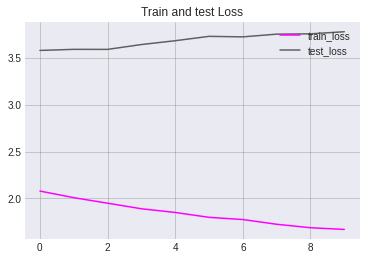

In [48]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(train_los, color = 'magenta')
plt.plot(test_los, color = '#606060')
plt.title('Train and test Loss')
plt.legend(['train_loss', 'test_loss'], loc = 'upper right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)

## **Inference**


Now, we'll grab some answers to questions from our dataset and see how well our model did.

In [40]:
def predict_duplicate(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('en_core_web_sm')
        #('en_core_web_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    # src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        hidden,cell = model.encoder(src_tensor)

        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    # attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
            # output, hidden, cell = model.decoder(trg_tensor, hidden, cell)

            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:]

Let's see how model predicts question from training set

In [41]:
example_idx = 20

src = vars(train_data.examples[example_idx])['question1']
trg = vars(train_data.examples[example_idx])['question2']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['what', 'does', 'it', 'feel', 'like', 'to', 'rob', 'a', 'bank', '?']
trg = ['what', 'is', 'it', 'like', 'to', 'rob', 'a', 'bank', '?']


In [42]:
pred_duplicate= predict_duplicate(src, SRC, TRG, model, device)

print(f'predicted trg = {pred_duplicate}')

predicted trg = ['what', 'is', 'it', 'like', 'to', 'rob', 'a', 'bank', '?', '<eos>']


Let's predict some answers from test set too

In [43]:
example_idx = 6

src = vars(test_data.examples[example_idx])['question1']
trg = vars(test_data.examples[example_idx])['question2']

print(f'src = {src}')
print(f'trg = {trg}')
pred_duplicate= predict_duplicate(src, SRC, TRG, model, device)

print(f'predicted trg = {pred_duplicate}')

src = ['what', 'are', 'things', 'which', 'i', 'can', 'export', 'from', 'india', '?']
trg = ['what', 'is', 'the', 'best', 'thing', 'to', 'export', 'from', 'india', '?']
predicted trg = ['what', 'are', 'some', 'ideas', 'to', 'to', 'buy', 'from', 'india', '?', '<eos>']


In [44]:
example_idx = 50

src = vars(test_data.examples[example_idx])['question1']
trg = vars(test_data.examples[example_idx])['question2']

print(f'src = {src}')
print(f'trg = {trg}')
pred_duplicate= predict_duplicate(src, SRC, TRG, model, device)

print(f'predicted trg = {pred_duplicate}')

src = ['why', 'are', 'there', 'still', 'poor', 'people', 'in', 'the', 'world', '?']
trg = ['why', 'do', 'you', 'think', 'there', 'are', 'so', 'many', 'poor', 'people', 'in', 'the', 'world', '?', 'how', 'did', 'it', 'get', 'that', 'way', '?', 'were', 'there', 'always', 'poor', 'people', '?']
predicted trg = ['why', 'are', 'there', 'so', 'many', 'people', 'in', 'the', 'world', '?', '<eos>']


In [45]:
example_idx = 10

src = vars(test_data.examples[example_idx])['question1']
trg = vars(test_data.examples[example_idx])['question2']

print(f'src = {src}')
print(f'trg = {trg}')
pred_duplicate= predict_duplicate(src, SRC, TRG, model, device)

print(f'predicted trg = {pred_duplicate}')

src = ['how', 'can', 'i', 'speak', 'english', 'fluently', 'and', 'fast', '?']
trg = ['how', 'do', 'i', 'speak', 'english', 'like', 'celebrities', '?']
predicted trg = ['how', 'can', 'i', 'speak', 'fluent', 'english', 'with', 'confidence', '?', '<eos>']


In [46]:
example_idx = 5


src = vars(test_data.examples[example_idx])['question1']
trg = vars(test_data.examples[example_idx])['question2']

print(f'src = {src}')
print(f'trg = {trg}')
pred_duplicate= predict_duplicate(src, SRC, TRG, model, device)

print(f'predicted trg = {pred_duplicate}')

src = ['who', 'is', 'the', 'most', 'badass', 'footballer', 'ever', '?']
trg = ['who', 'is', 'the', 'most', 'badass', 'footballer', 'ever', '?', 'why', '?']
predicted trg = ['who', 'is', 'the', 'most', 'overrated', 'footballer', '?', '<eos>']


In [49]:
example_idx = 25


src = vars(test_data.examples[example_idx])['question1']
trg = vars(test_data.examples[example_idx])['question2']

print(f'src = {src}')
print(f'trg = {trg}')
pred_duplicate= predict_duplicate(src, SRC, TRG, model, device)

print(f'predicted trg = {pred_duplicate}')

src = ['which', 'laptop', 'is', 'better', 'till', '60000', '?']
trg = ['which', 'is', 'the', 'best', 'gaming', 'laptop', 'under', 'rs', '60000', '?']
predicted trg = ['what', 'is', 'the', 'best', 'laptop', 'under', 'rs.60000', 'in', 'india', '?', '<eos>']
